In [19]:
import sys
import os
import requests
from pathlib import Path
import torch
import numpy as np
from torchvision import transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from PIL import Image

import models_mae


def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip(image * 255, 0, 255).int())
    plt.title(title, fontsize=28)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mmae_vit_base_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img) # [h, w, c]

    # make it a batch-like
    x = x.unsqueeze(dim=0) # [n, h, w, c]
    x = torch.einsum('nhwc->nchw', x) # [n, c, h, w]

    if x.shape[1] == 3:
        x = x.mean(dim=1, keepdim=True)  # 將 RGB 轉換為灰階

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.75)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *1)  # (N, H*W, p*p*1)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # 將 mask 的區域設置為綠色
    green_mask = torch.zeros(1,224,224,3)  # 創建一個與 im_masked 形狀相同的張量
    green_mask[:, :, :, :] = torch.tensor([0, 1, 0]).view(1, 1, 1, 3)   # 將綠色設置為 (0, 1, 0) 的 RGB
    im_masked_colored = im_masked + green_mask * mask

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 8]

    plt.subplot(1, 4, 1)

    show_image(x[0].repeat(1,1,3), "original")

    plt.subplot(1, 4, 2)
    # show_image(im_masked[0].repeat(1,1,3), "masked")
    show_image(im_masked_colored[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0].repeat(1,1,3), "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0].repeat(1,1,3), "reconstruction + visible")
    plt.tight_layout()



transform_train = transforms.Compose([
            transforms.ToTensor()])
dataset_train = datasets.ImageFolder(os.path.join(r'D:\2d_composite_mesh_generator\inclusion_train'), transform=transform_train)
dataset_valid = datasets.ImageFolder(os.path.join(r'D:\2d_composite_mesh_generator\circle_valid'), transform=transform_train)


img_tensor, label = dataset_train[0] # (C, H, W)
img_tensor = torch.einsum('chw->hwc', img_tensor)




############################

chkpt_dir = Path(r'D:\Material_mask_autoencoder\output_dir\circle\checkpoint-799.pth')
model_mae = prepare_model(chkpt_dir, arch='mmae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


C:\Users\Berry\AppData\Local\Temp\ipykernel_31084\1870299500.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(chkpt_dir, map_location='cpu')


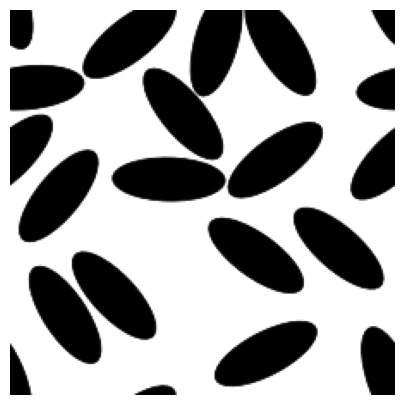

In [21]:
i=0
img_tensor, label = dataset_train[i] # (C, H, W)
img_tensor = torch.einsum('chw->hwc', img_tensor)

plt.rcParams['figure.figsize'] = [5, 5]
show_image(img_tensor)


MAE with pixel reconstruction:


C:\Users\Berry\AppData\Local\Temp\ipykernel_31084\1870299500.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img) # [h, w, c]


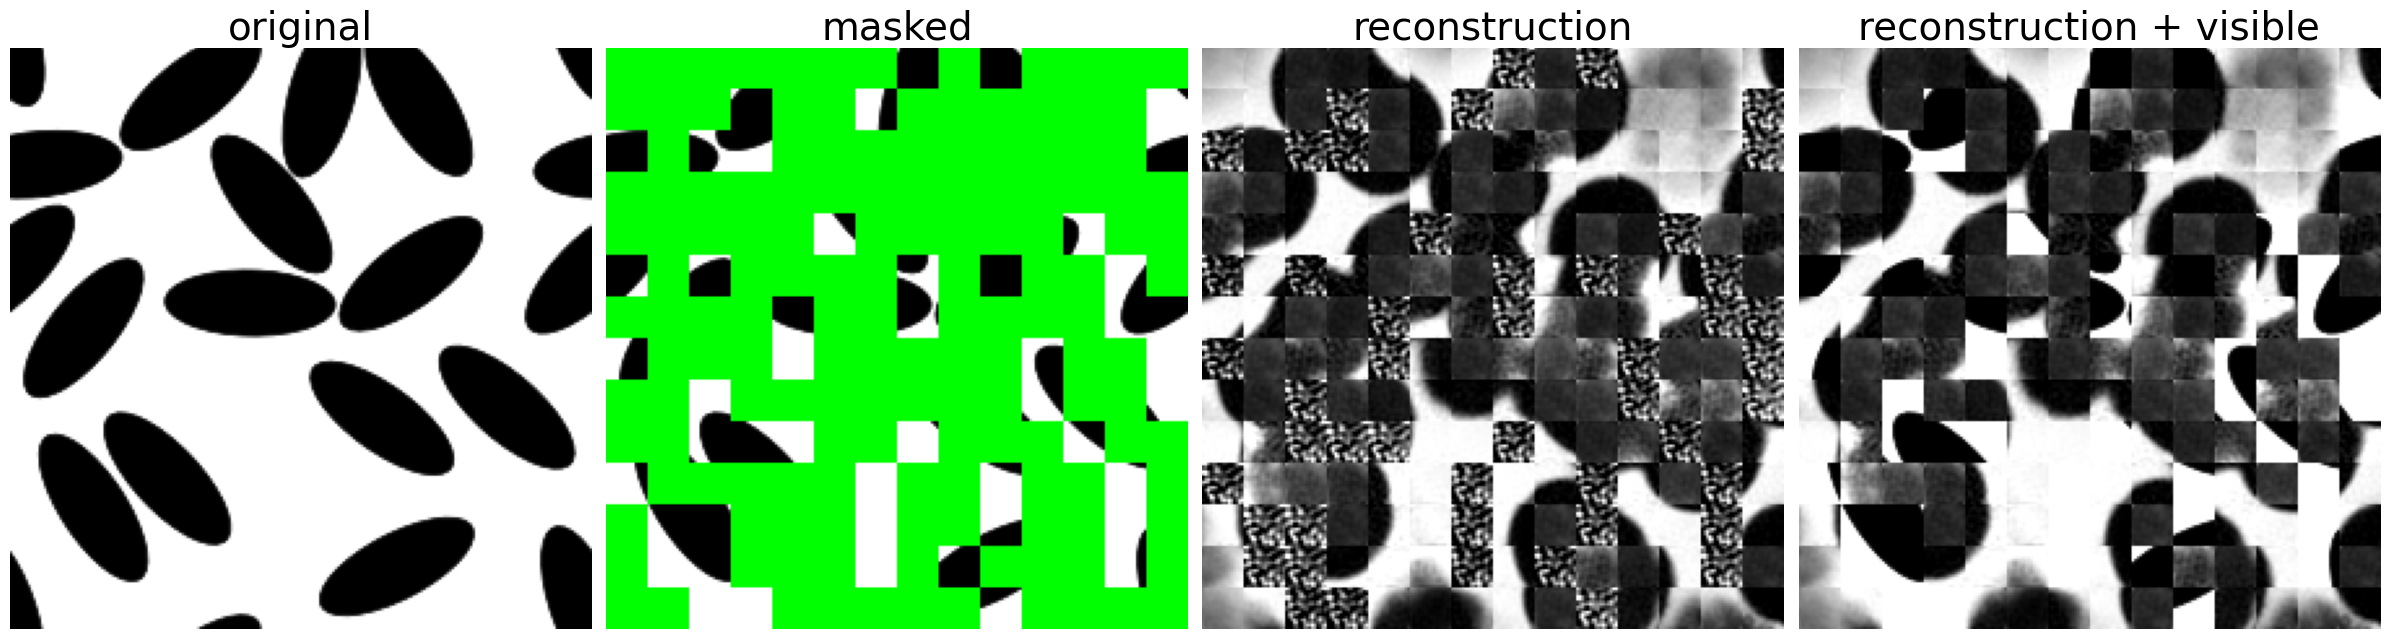

In [22]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_image(img_tensor, model_mae)
